In [ ]:

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

import dos


In [ ]:

simulation_path = './dos/BendingModes'
sim = dos.DOS(simulation_path, show_timing=2)


In [ ]:

sim.start()


In [ ]:

sim.pctComplete


### Read and plot LOS data

---


In [ ]:
import pickle
import numpy as np
import scipy.io as sio

file_path = "../CUDAIMS-NSEE/datafiles/CUDAIMSsysDt/memorymaps/dgnf.dat"
dgnf_mm = np.memmap(file_path, dtype=np.float32, mode='r+', shape=(21,84))
dgnf = dgnf_mm.view(dtype = np.float32, type = np.ndarray)

OSS_M1_LOS = sim.logs.entries['FEM']['OSS_M1_LOS'].timeSeries[1].T
MC_M2_LOS_6D = sim.logs.entries['FEM']['MC_M2_LOS_6D'].timeSeries[1].T

dec = 10
dt  = OSS_M1_LOS.shape[1]
nt  = dt // dec

LOS_outs = np.memmap('./LOS.dat', dtype=np.float32, mode='w+', shape=(21,dt))
for k in range(dec):
    ki, kii = nt * k, nt * (k + 1)
    if kii < dt:
        outs = np.concatenate((OSS_M1_LOS[:,ki:kii], MC_M2_LOS_6D[:,ki:kii]), axis=0)
    else:
        outs = np.concatenate((OSS_M1_LOS[:,ki:], MC_M2_LOS_6D[:,ki:]), axis=0)
    los  = dgnf @ outs 
    LOS_outs[:,ki:kii] = los[:,:]
    
LOS_sim = sio.loadmat('./LOS.mat')['outs']

In [ ]:
index = 5

signal = LOS_outs[index, :10000]
sim_signal = LOS_sim[index, :10000]

plt.figure(figsize = (26,18))
plt.plot(signal, lw = 3.0)
plt.plot(sim_signal, lw = 1.3)
plt.show()

### Plotting simulation logs

---

Specifically plot the bending modes outputs


In [ ]:
plt.figure(figsize = (16,8))
plt.plot(*sim.logs.entries['FEM']['Bending_modes'].timeSeries)
plt.show()

### Save a particular output in memory map

---

In [ ]:
signal_values.shape

In [ ]:
import numpy as np

signal_name   = 'bendingmodes_SS'
signal_values = sim.logs.entries['FEM']['Bending_modes'].timeSeries[1]

saved_mem_map = np.memmap('./variables/'+signal_name+'.dat', dtype=np.float32, mode='w+', shape=signal_values.shape)
saved_mem_map[:,:] = signal_values[:,:]
del saved_mem_map

### Infomation analysis of the bending modes outputs

---



In [ ]:
import numpy as np

shape__ = (20000, 1144)
bm_ssr = np.memmap('./variables/bendingmodes_SS.dat', dtype=np.float32, mode='r+', shape=shape__)
bm_stf = np.memmap('./variables/bendingmodes_ST.dat', dtype=np.float32, mode='r+', shape=shape__)

index = 15

plt.figure(figsize=(16,8))
plt.plot(bm_ssr[:,index], '-', label='Steady State Response')
plt.plot(bm_stf[:,index], '--', label='Stiffness Matrix')
plt.legend()
plt.show()


### Terminate the simulation

---

In [ ]:
sim.terminate

In [ ]:

import numpy as np
import scipy.io as sio

from utils import LargeCompute


In [ ]:

shape_st_ = (11000,20000)
states = np.memmap('./variables/states.dat', dtype=np.float32, mode='r+', shape=shape_st_)

C = sio.loadmat('../database/matmodels/consolidated_withSSBM.mat')['C']


data = sio.loadmat('./dos/BendingModes/FEM_IO_WBM.mat')
fem_outputs=[(x[0][0],y[0]) for x,y in zip(data['FEM_IO']['outputs_name'][0,0],data['FEM_IO']['outputs_size'][0][0])]

i_sum = 0
for k in fem_outputs:
    if k[0] != 'M1_surfaces_d':
        if k[0] != 'Bending_modes':
            i_sum += k[1]
    else:
        ref_size = k[1]
i_, ii_ = i_sum, i_sum + ref_size


C = C[i_:ii_,:]

indexes = range(2,C.shape[0],3)
C = C[indexes, :]


lc = LargeCompute()
displacements_ptt = lc.dot_time(C, states)

In [ ]:

shape_bm_ = (20000, 1144)
bending_modes = np.memmap('./variables/bendingmodes_SS.dat', dtype=np.float32, mode='r+', shape=shape_bm_)

#shape_dp_ = (20000, 5127)
#displacements = np.memmap('./variables/displacements.dat', dtype=np.float64, mode='r+', shape=shape_dp_)

Read the transformation matrix

In [ ]:
import scipy.io as sio

U_ = sio.loadmat('./variables/auxiliar/SSBM_transformation_matrices.mat')['U_']

Q_ = sio.loadmat('./variables/auxiliar/SSBM_transformation_matrices.mat')['Q_']


Recover the displacements from bending modes:

In [ ]:
shape_dp_ = (5127, 20000)

lc = LargeCompute()

bm_displacements = np.memmap('./variables/bm_displacements_.dat', dtype=np.float32, mode='w+', shape=shape_dp_)
displacements = np.memmap('./variables/displacements_.dat', dtype=np.float32, mode='w+', shape=shape_dp_)
for k in range(U_.shape[0]):
    i = k * 165
    ki = k * 742
    if k != U_.shape[0]-1:
        ii = (k + 1) * 165 
        kii = (k + 1) * 742
    else:
        ii = i + 154
        kii = ki + 675
    bm_displacements[ki:kii,:] = lc.bm_to_disp_time(U_[k,0], bending_modes[:,i:ii].T)
    displacements[ki:kii,:] = lc.remove_ptt_from_disp(Q_[k,0], displacements_ptt[ki:kii,:])

print('Simulated displacements shape: ', displacements.shape)
print('Bending modes displacements shape: ', bm_displacements.shape)

In [ ]:
import scipy.linalg as sli

def remove_ptt(ptt, displacements, vartype=np.float32):

    #    get the shape of the displacements
    _size = displacements.shape
    result = np.zeros(_size)
    for k in range(_size[1]):
        _ptt = sli.lstsq(ptt, displacements[:,k])[0]
        print(displacements[:,k].shape, _ptt.shape, ptt.shape)
        result[:,k] = displacements[:,k] - np.dot(ptt, np.array(_ptt))

    return result

In [ ]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

index = 1000

plt.figure(figsize=(16,8))
plt.plot(displacements_ptt[index,:])
plt.show()


In [ ]:
displacements_ptt.shape

In [ ]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

index = 50

plt.figure(figsize=(16,16))
plt.subplot(3,1,1)
plt.plot(displacements[index,:], '-', c='C1', label='Simulated without PTT')
plt.legend()
plt.subplot(3,1,2)
plt.plot(bm_displacements[index,:], c='C2', label='From bending modes')
plt.legend()
plt.subplot(3,1,3)
plt.plot(displacements_ptt[index,:],'-', c='C3', label='Simulated with PTT')
plt.legend()
plt.show()

## Create displacements and PTT movie
---

In [ ]:
import numpy as np
import cupy as cp 
import scipy.io as sio
import scipy.spatial as ssp
import matplotlib.pyplot as plt
import matplotlib.tri as mtri   
import matplotlib.animation as animation
import matplotlib as mpl

from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--')

In [ ]:
_shape = (742, 20000)
_shape_unity = (742,)
resolution = 100

z = {
    'disp': np.memmap('./variables/displacements/timeseries.dat', dtype=np.float32, mode='r+', shape=_shape),
    'ptt' : np.memmap('./variables/pistonTipTilt/timeseries.dat', dtype=np.float32, mode='r+', shape=_shape)
}


In [ ]:
data_path = '../database/bendingmodes'
file_name = '/SSBM_transformation_matrices.mat'

data = sio.loadmat(data_path + file_name)

In [ ]:
points = data['POS_incell'][0,0]
tri = ssp.Delaunay(np.array(points))

xi = points[:,0].reshape(_shape_unity)
yi = points[:,1].reshape(_shape_unity)

triang = mtri.Triangulation(xi, yi, tri.simplices.copy())
z_values = np.array(z['disp'][:,800]).reshape((_shape[0],))

interp_cubic_geom = mtri.CubicTriInterpolator(triang, z_values, kind='geom')
xi = np.linspace(xi.min(), xi.max(), resolution)
yi = np.linspace(yi.min(), yi.max(), resolution)
xii, yii = np.meshgrid(xi, yi)
zi_cubic_geom = interp_cubic_geom(xii, yii)

z_min, z_max = z['disp'][:,:].min(), z['disp'][:,:].max()

plt.figure(figsize=(8,8))
plt.contourf(xii, yii, zi_cubic_geom)
plt.show()

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
def animate(index, z_disp, opt, axis):
    '''
        Use normalized filled contours to represent the image.
    '''
    proportion = 10**3
    if index is None:
        print('This index is not real for plotting...')
    triang = opt['basic']['triang']
    x_axis = opt['basic']['x_axis'] 
    y_axis = opt['basic']['y_axis']
    
    if opt['norm']['type'] == 'log':
        opt['norm']['max'] = np.log10(opt['norm']['max'])
        opt['norm']['min'] = np.log10(opt['norm']['min'])
        z_disp[:,index]    = np.log10(z_disp[:,index])
    
    z_values = np.array(proportion * z_disp[:,index].reshape(z_disp.shape[0],))
    interp_cubic_geom = mtri.CubicTriInterpolator(triang, z_values, kind='geom')
    zi_cubic_geom = interp_cubic_geom(x_axis, y_axis)
    
    # Define the possible countours
    if opt['norm']['type'] == 'linear':
        cont = axis.contourf(x_axis, y_axis, zi_cubic_geom,
                              vmin=opt['norm']['min'],
                              vmax=opt['norm']['max'],
                              levels=25)
    elif opt['norm']['type'] == 'log':
        cont = axis.contourf(x_axis, y_axis, zi_cubic_geom,
                              vmin=opt['norm']['min'],
                              vmax=opt['norm']['max'])
    elif opt['norm']['type'] == 'concentrated':
        cont = axis.contourf(x_axis, y_axis, zi_cubic_geom, levels=25)
    else:
        print('Error: no contour type found!')
    
    return cont


In [ ]:
_time = 10000 #(s)
_jump = 10
_mation = list()

_opt_i = {
    'basic': {
        'triang' : triang,
        'x_axis' : xii,
        'y_axis' : yii,
    },
    'norm' : {
        'type' : 'concentrated',
        'min' : z_min,
        'max' : z_max,
    }
}

_opt_ii = {
    'basic': {
        'triang' : triang,
        'x_axis' : xii,
        'y_axis' : yii,
    },
    'norm' : {
        'type' : 'concentrated',
        'min' : z_min,
        'max' : z_max,
    }
}


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
plt.subplots_adjust(hspace=.0, wspace=.2)

for k in range(0,_time,_jump):
    _image1 = animate(k, z['disp'], _opt_i, ax1)
    _image2 = animate(k, z['ptt'], _opt_ii, ax2)
    _mation.append(_image1.collections + _image2.collections)

# Create the displacement
cbar1 = fig.colorbar(_image1, ax=ax1, shrink=0.8, spacing='proportional')
cbar1.set_label('xE03')

ax1.set_aspect('equal')
ax1.set_title('Displacements')
ax1.set_xlim(xi.min(), xi.max())
ax1.set_ylim(yi.min(), yi.max())

# Create the piston tip and tilt
cbar2 = fig.colorbar(_image2, ax=ax2, shrink=0.8, spacing='proportional')
cbar2.set_label('xE03')

ax2.set_aspect('equal')
ax2.set_title('Piston Tip Tilt')
ax2.set_xlim(xi.min(), xi.max())
ax2.set_ylim(yi.min(), yi.max())

In [ ]:
ani = animation.ArtistAnimation(fig,_mation,interval=500,repeat=False,blit=True)
ani.save('disp_and_ptt_movie.mp4',writer='ffmpeg')


## Create curve and comparison visualizations
---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--')

In [ ]:
_shape = (742, 20000)
_shape_unity = (742,)
resolution = 100

z = {
    'disp': np.memmap('./variables/displacements/timeseries.dat', dtype=np.float32, mode='r+', shape=_shape),
    'ptt' : np.memmap('./variables/pistonTipTilt/timeseries.dat', dtype=np.float32, mode='r+', shape=_shape)
}


In [ ]:
_indexes = [1, 20, 40, 80]

fig, ax = plt.subplots(3,1, figsize=(16,16))

_cindex = 0
for item in _indexes:
    _color = 'C' + str(_cindex)
    ax[0].plot(z['disp'][item,:], linewidth=3, color=_color)
    ax[1].plot(z['ptt'][item,:], linewidth=3, color=_color)
    error = z['disp'][item,:] - z['ptt'][item,:]
    ax[2].plot(error, linewidth=3, color=_color)
    _cindex += 1

plt.show()

## Create bending modes _pos process_
---

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--')

In [8]:
_segmentId = 1

_shape = (742, 20000)
_shape_unity = (742,)

disp =  np.memmap('./variables/displacements/timeseries.dat', 
                  dtype=np.float32, mode='r+', shape=_shape)

In [9]:
import scipy.io as sio
from utils import LargeCompute

data = sio.loadmat('../database/bendingmodes/SSBM_transformation_matrices.mat')
U_trans = data['U_'][_segmentId-1,0]


In [ ]:

lc = LargeCompute(onCuda=True)
bmodes = lc.dot_time(U_trans.T, disp, varname='bendingmodes')
abs_bmodes = np.abs(bmodes[:,:])

In [ ]:

fig = plt.figure(figsize=(16,8))
ax = plt.axes(xlim = (0, bmodes.shape[0]),
              ylim = (0, abs_bmodes.max()) )
line, = ax.plot([], [], lw=3)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i, _bmodes):
    _size = _bmodes.shape[0]
    x = np.array(range(_size))
    line.set_data(x, _bmodes[:, i])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(abs_bmodes,),
                               frames=10000, interval=20, blit=True)

anim.save('bendingmodes_importance.mp4', writer='ffmpeg')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,16))
ax1.set_title('Bending modes magnitude')
ax2.set_title('Bending modes magnitude variation')
_x_data = np.array(range(bmodes.shape[1]))
for k in range(bmodes.shape[0]):
    ax1.plot(_x_data, bmodes[k,:], lw=3)
    ax2.plot(_x_data[:-1], np.diff(bmodes[k,:]), lw=3)
plt.show()

## Recover the displacements from bmodes
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--')

In [2]:
_segmentId = 1

_shape = (165, 20000)
bmodes = np.memmap('./LargeComputeLogs/dot_time/bendingmodes.dat', 
                  dtype=np.float32, mode='r+', shape=_shape)

In [3]:
import scipy.io as sio

data = sio.loadmat('../database/bendingmodes/SSBM_transformation_matrices.mat')
U_trans = data['U_'][_segmentId-1,0]

In [4]:
from utils import LargeCompute

lc = LargeCompute(onCuda=True)
rec_disp = lc.bm_to_disp_time(U_trans, bmodes, varname='recovered_displacements')

In [5]:
_shape = (742, 20000)
disp =  np.memmap('./variables/displacements/timeseries.dat', 
                  dtype=np.float32, mode='r+', shape=_shape)
ptt =  np.memmap('./variables/pistonTipTilt/timeseries.dat', 
                  dtype=np.float32, mode='r+', shape=_shape)

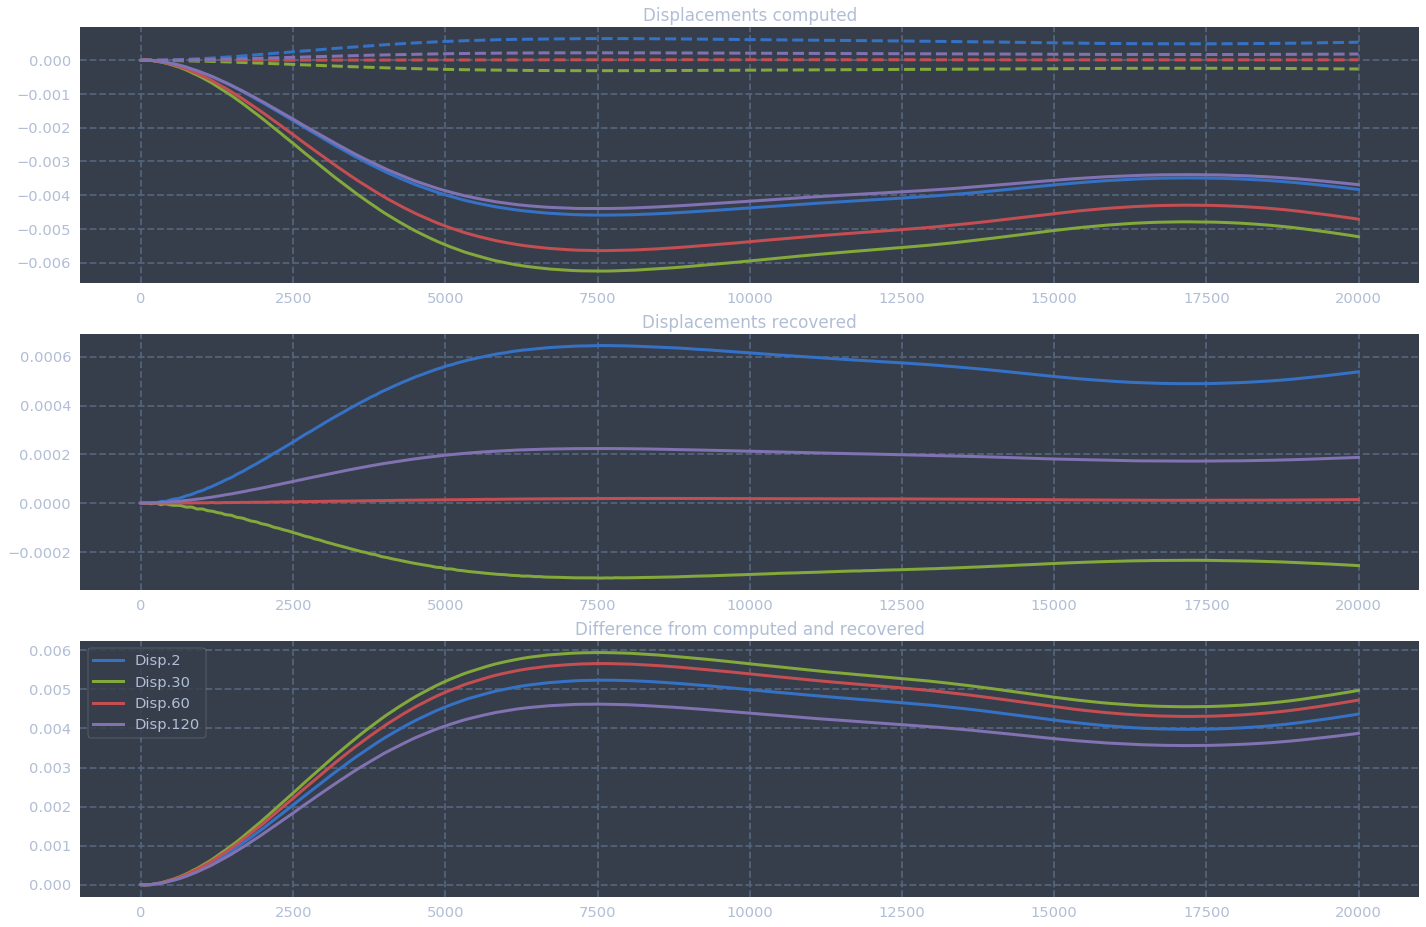

In [6]:
_indexes = [2, 30, 60, 120]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,16))
ax1.set_title('Displacements computed')
ax2.set_title('Displacements recovered')
ax3.set_title('Difference from computed and recovered')
_cindex = 0
for k in _indexes:
    color = 'C' + str(_cindex)
    ax1.plot(disp[k,:], lw=3, c=color, label='Disp.' + str(k))
    ax1.plot(rec_disp[k,:], '--', lw=3, c=color, label='Disp.' + str(k))
    ax2.plot(rec_disp[k,:], lw=3, c=color, label='Disp.' + str(k))
    ax3.plot(rec_disp[k,:] - disp[k,:], lw=3, c=color, label='Disp.' + str(k))
    _cindex += 1
plt.legend()
plt.show()

## Check the bending modes movements when just mount moves
---

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plt.xlim(xi.min(), xi.max())
plt.ylim(yi.min(), yi.max())
plt.title('Displacements plotting',fontsize=20)

ani = animation.FuncAnimation(fig, animate, 
                            frames=100, 
                            repeat=True, 
                            fargs=(z['disp'], _opt_i, ax))
ani.save('./animated.mp4')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xlim(xi.min(), xi.max())
plt.ylim(yi.min(), yi.max())
plt.title('Displacements plotting',fontsize=20)

ani = animation.FuncAnimation(fig, animate, 
                            frames=100, 
                            repeat=True, 
                            fargs=(z['disp'], _opt_i, ax1))
ani.save('./animated.mp4')

In [ ]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * cos(delta) * cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * sin(delta) * cos(delta)
                + M2 * G * sin(state[2]) * cos(delta)
                + M2 * L2 * state[3] * state[3] * sin(delta)
                - (M1+M2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (M1+M2) * G * sin(state[0]) * cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * sin(delta)
                - (M1+M2) * G * sin(state[2]))
               / den2)

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0, 20, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(1, len(y)),
                              interval=dt*1000, blit=True, init_func=init)
plt.show()